Credit goes to https://colab.research.google.com/github/count0/colab-gt/blob/master/colab-gt.ipynb for the steps to use graph_tool in Colab.

In [1]:
!echo "deb http://downloads.skewed.de/apt jammy main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard
!pip install gravis

Executing: /tmp/apt-key-gpghome.lzOwRl7k17/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:7 http://downloads.skewed.de/apt jammy InRelease [7,535 B]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,796 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa

In [2]:
from graph_tool.all import *

g = load_graph("HepPh_with_louvain_and_label.graphml")

In [3]:
from datetime import date, datetime
from dateutil.relativedelta import relativedelta

date_cutoffs = []

curr_date = datetime.strptime("1994-01-01", "%Y-%m-%d").date()
while curr_date.strftime("%Y-%m-%d") < "2003-01-01":
    date_cutoffs.append(curr_date.strftime("%Y-%m-%d"))
    curr_date += relativedelta(years=+1)

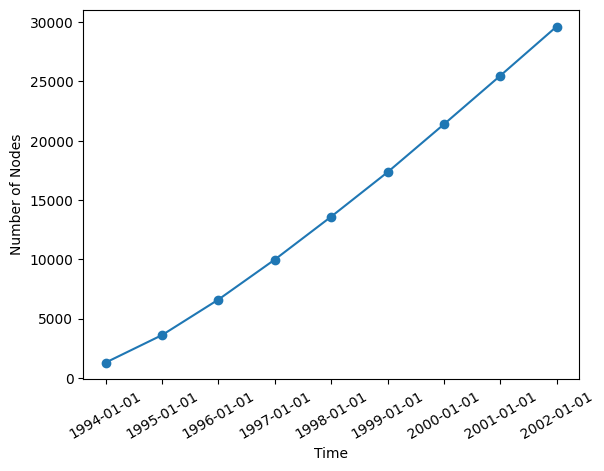

In [4]:
from matplotlib import pyplot

# https://stackoverflow.com/questions/30839929/graph-tool-graphview-object
# https://graph-tool.skewed.de/static/doc/autosummary/graph_tool.stats.vertex_hist.html
# https://snap.stanford.edu/class/cs224w-2018/reports/CS224W-2018-50.pdf
# https://ddu.ext.unb.ca/6634/Lecture_notes/Lec3_network_statistics_handout.pdf

# time_slices = list(range(len(date_cutoffs)))
num_vert_per_slice = []
num_edge_per_slice = []
clustering_per_slice = []
out_deg_dist_per_slice = []
in_deg_dist_per_slice = []
node_closeness_per_slice = []
diameter_per_slice = []
in_assortativity_per_slice = []
out_assortativity_per_slice = []
total_assortativity_per_slice = []

for slice_idx in range(len(date_cutoffs)):
    u = GraphView(g, vfilt=lambda v: g.vp.date[v] < date_cutoffs[slice_idx])
    u = extract_largest_component(u, directed=False, prune=True)

    my_node_closeness = []
    node_closeness = closeness(u, harmonic=True)
    for v in u.iter_vertices():
        my_node_closeness.append((u.vp.arxiv_id[v], node_closeness[v]))
    node_closeness_per_slice.append(sorted(my_node_closeness, key=lambda x: x[1], reverse=True))

    num_vert_per_slice.append(u.num_vertices())
    num_edge_per_slice.append(u.num_edges())

    clustering_per_slice.append(global_clustering(u)[0])

    u.set_directed(is_directed=False)
    dist, ends = pseudo_diameter(u)
    u.set_directed(is_directed=True)

    diameter_per_slice.append(dist)

    in_assortativity_per_slice.append(assortativity(u, "in")[0])
    out_assortativity_per_slice.append(assortativity(u, "out")[0])
    total_assortativity_per_slice.append(assortativity(u, "total")[0])

    out_deg_dist_per_slice.append(vertex_hist(u, "out", float_count=False))
    in_deg_dist_per_slice.append(vertex_hist(u, "in", float_count=False))

pyplot.xlabel("Time")
pyplot.ylabel("Number of Nodes")
pyplot.xticks(rotation=30)
pyplot.plot(date_cutoffs, num_vert_per_slice, 'o-')
pyplot.savefig("num_nodes_vs_time.png", bbox_inches = 'tight')
pyplot.show()

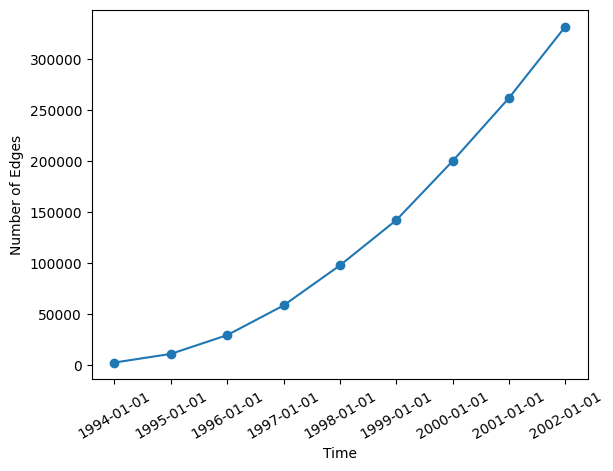

In [5]:
pyplot.xlabel("Time")
pyplot.ylabel("Number of Edges")
pyplot.xticks(rotation=30)
pyplot.plot(date_cutoffs, num_edge_per_slice, 'o-')
pyplot.savefig("num_edges_vs_time.png", bbox_inches = 'tight')
pyplot.show()

Slope of Line of Best Fit (Densification Power Law): 1.5584461382051955


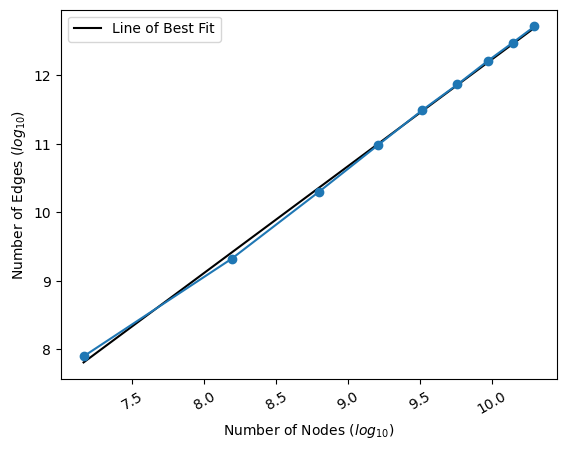

In [6]:
import numpy as np

# https://www.cs.cmu.edu/~jure/pubs/powergrowth-kdd05.pdf
# https://numpy.org/doc/stable/reference/generated/numpy.log.html
# https://stackoverflow.com/questions/65240790/finding-the-gradient-of-best-fit-line-in-python

slope, intercept = np.polyfit(np.log(num_vert_per_slice), np.log(num_edge_per_slice), 1)
print("Slope of Line of Best Fit (Densification Power Law):", slope)
pyplot.plot(np.unique(np.log(num_vert_per_slice)), np.poly1d(np.polyfit(np.log(num_vert_per_slice), np.log(num_edge_per_slice), 1))(np.unique(np.log(num_vert_per_slice))), color = 'k', label="Line of Best Fit")
pyplot.plot(np.log(num_vert_per_slice), np.log(num_edge_per_slice), 'o-')
pyplot.xlabel("Number of Nodes ($log_{10}$)")
pyplot.ylabel("Number of Edges ($log_{10}$)")
pyplot.xticks(rotation=30)
pyplot.legend()
pyplot.savefig("log_num_edges_vs_log_num_nodes.png", bbox_inches = 'tight')
pyplot.show()

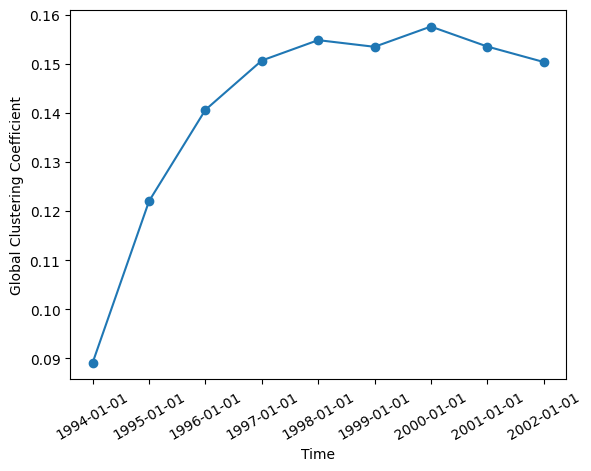

In [7]:
pyplot.xlabel("Time")
pyplot.ylabel("Global Clustering Coefficient")
pyplot.xticks(rotation=30)
pyplot.plot(date_cutoffs, clustering_per_slice, 'o-')
pyplot.savefig("clustering_vs_time.png", bbox_inches = 'tight')
pyplot.show()

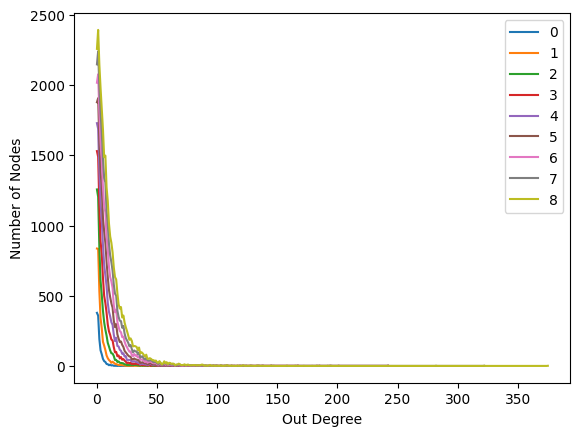

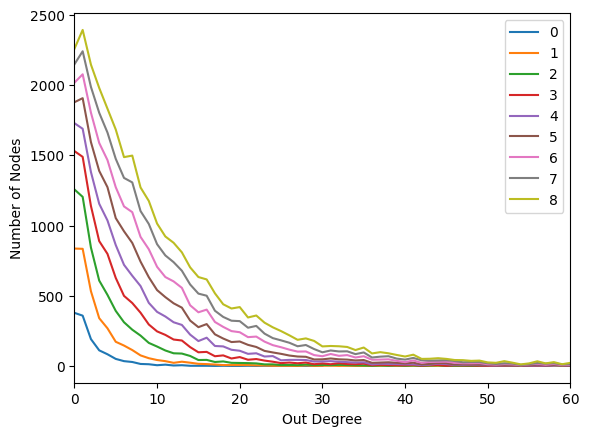

In [8]:
for slice_idx,i in enumerate(out_deg_dist_per_slice):
    pyplot.plot(i[1][:-1],i[0], label=str(slice_idx))
pyplot.legend()
pyplot.xlabel("Out Degree")
pyplot.ylabel("Number of Nodes")
pyplot.savefig("num_nodes_vs_out_degree.png", bbox_inches = 'tight')
pyplot.show()

for slice_idx,i in enumerate(out_deg_dist_per_slice):
    pyplot.plot(i[1][:-1],i[0], label=str(slice_idx))
ax = pyplot.gca()
ax.set_xlim([0, 60])
pyplot.legend()
pyplot.xlabel("Out Degree")
pyplot.ylabel("Number of Nodes")
pyplot.savefig("num_nodes_vs_out_degree_zoom.png", bbox_inches = 'tight')
pyplot.show()

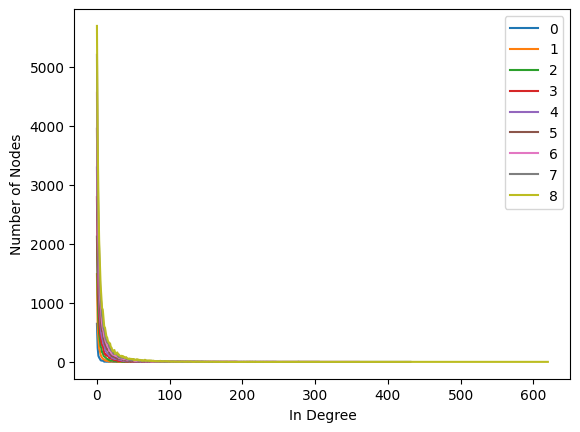

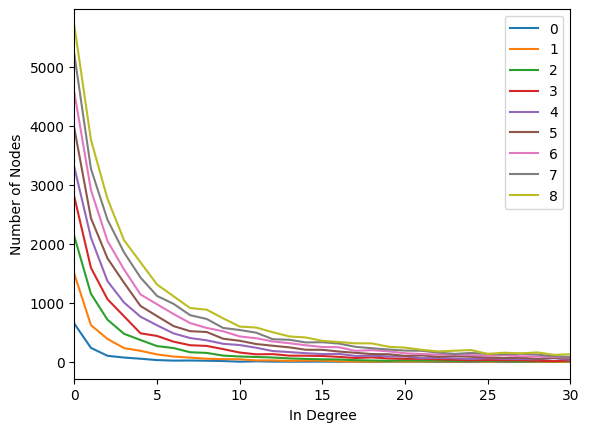

In [9]:
for slice_idx,i in enumerate(in_deg_dist_per_slice):
    pyplot.plot(i[1][:-1],i[0], label=str(slice_idx))
pyplot.legend()
pyplot.xlabel("In Degree")
pyplot.ylabel("Number of Nodes")
pyplot.savefig("num_nodes_vs_in_degree.png", bbox_inches = 'tight')
pyplot.show()

for slice_idx,i in enumerate(in_deg_dist_per_slice):
    pyplot.plot(i[1][:-1],i[0], label=str(slice_idx))
ax = pyplot.gca()
ax.set_xlim([0, 30])
pyplot.legend()
pyplot.xlabel("In Degree")
pyplot.ylabel("Number of Nodes")
pyplot.savefig("num_nodes_vs_in_degree_zoom.png", bbox_inches = 'tight')
pyplot.show()

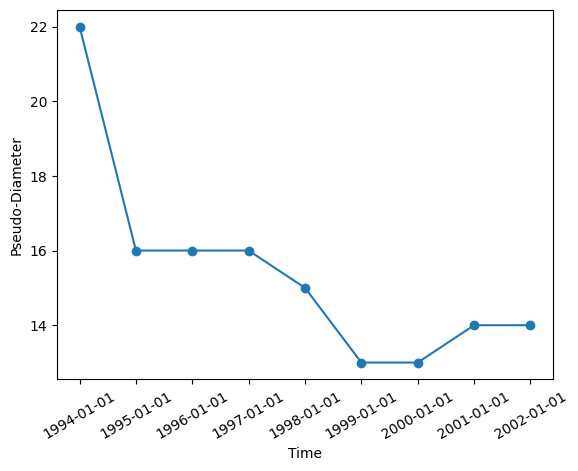

In [10]:
pyplot.xlabel("Time")
pyplot.ylabel("Pseudo-Diameter")
pyplot.xticks(rotation=30)
pyplot.plot(date_cutoffs, diameter_per_slice, 'o-')
pyplot.savefig("pseudo_diameter_vs_time.png", bbox_inches = 'tight')
pyplot.show()

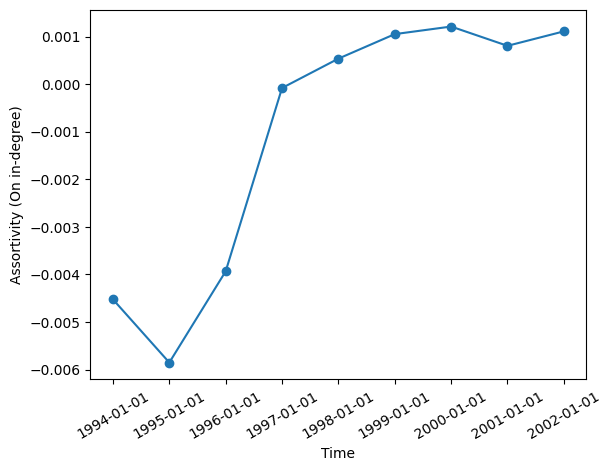

In [11]:
pyplot.xlabel("Time")
pyplot.ylabel("Assortivity (On in-degree)")
pyplot.xticks(rotation=30)
pyplot.plot(date_cutoffs, in_assortativity_per_slice, 'o-')
pyplot.savefig("in_assortativity_vs_time.png", bbox_inches = 'tight')
pyplot.show()

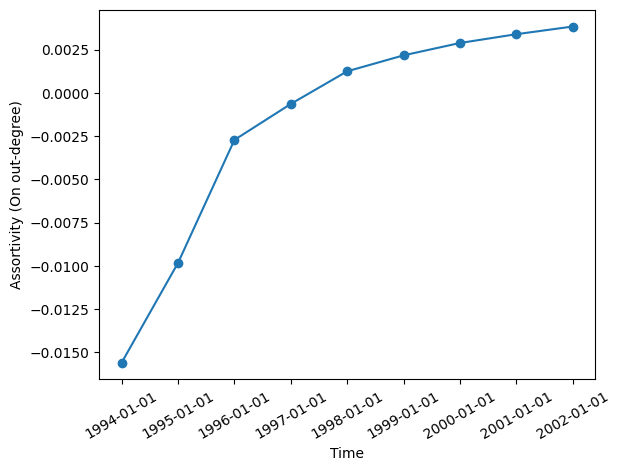

In [12]:
pyplot.xlabel("Time")
pyplot.ylabel("Assortivity (On out-degree)")
pyplot.xticks(rotation=30)
pyplot.plot(date_cutoffs, out_assortativity_per_slice, 'o-')
pyplot.savefig("out_assortativity_vs_time.png", bbox_inches = 'tight')
pyplot.show()

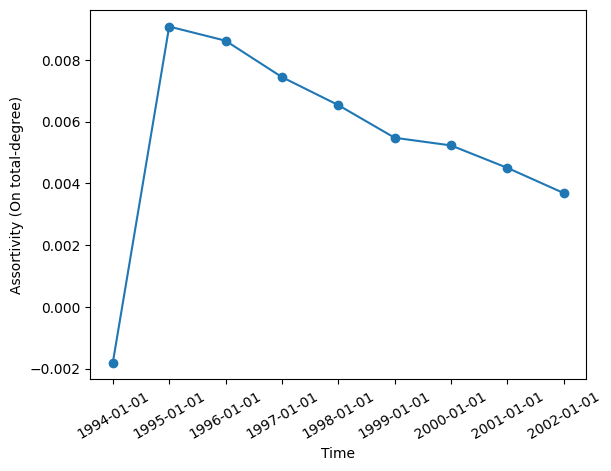

In [13]:
pyplot.xlabel("Time")
pyplot.ylabel("Assortivity (On total-degree)")
pyplot.xticks(rotation=30)
pyplot.plot(date_cutoffs, total_assortativity_per_slice, 'o-')
pyplot.savefig("total_assortativity_vs_time.png", bbox_inches = 'tight')
pyplot.show()